In [1]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import math
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

Data:

In [2]:
data = pd.read_csv('data/heart_disease_health_indicators_BRFSS2015.csv')
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Train test split:

In [3]:
# split 1
X, y = data.drop('HeartDiseaseorAttack', axis=1), data['HeartDiseaseorAttack']
X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
print(X_train1.shape, X_val1.shape)
print(y_train1.shape, y_val1.shape)

(202944, 21) (50736, 21)
(202944,) (50736,)


In [4]:
# split 2
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
print(X_train2.shape, X_val2.shape)
print(y_train2.shape, y_val2.shape)

(177576, 21) (76104, 21)
(177576,) (76104,)


In [5]:
# split 3
X_train3, X_val3, y_train3, y_val3 = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
print(X_train3.shape, X_val3.shape)
print(y_train3.shape, y_val3.shape)

(152208, 21) (101472, 21)
(152208,) (101472,)


In [6]:
def calculate_discriminability_multivariate(X, y):
    X1 = X[y == 1]
    X0 = X[y == 0]
    
    # S_B
    m1 = np.mean(X1, axis=0)
    m0 = np.mean(X0, axis=0)
    # S_B 
    diff = (m1 - m0).reshape((-1,1))
    S_B = diff.dot(diff.T)

    # S_W
    S1 = np.cov(X1, rowvar=False) 
    S0 = np.cov(X0, rowvar=False)
    Sw = S1 + S0
    
    # discriminant
    J = np.matrix.trace(S_B) / np.matrix.trace(Sw)
    
    return J

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train1)

# Tính và in độ phân biệt
J = calculate_discriminability_multivariate(X_scaled, y_train1)
print(f"Độ phân biệt tổng thể: {J:.4f}")

Độ phân biệt tổng thể: 0.1074


## 1. Dealing with imbalanced dataset

#### 1.1. Oversampling:

a. Random oversampling

In [6]:
def resample_data(X, y):
    imbalanced_data = X.copy()
    imbalanced_data['HeartDiseaseorAttack'] = y.copy()

    minority_class = imbalanced_data[imbalanced_data['HeartDiseaseorAttack'] == 1.0]
    majority_class = imbalanced_data[imbalanced_data['HeartDiseaseorAttack'] == 0.0]

    # upsample the minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

    # combine the upsampled minority class with the majority class
    balanced_data = pd.concat([majority_class, minority_upsampled])
    X_ro, y_ro = balanced_data.drop('HeartDiseaseorAttack', axis=1), balanced_data['HeartDiseaseorAttack']
    return X_ro, y_ro

X_train1_ro, y_train1_ro = resample_data(X_train1, y_train1)
X_train2_ro, y_train2_ro = resample_data(X_train2, y_train2)
X_train3_ro, y_train3_ro = resample_data(X_train3, y_train3)

b. SMOTE (Synthetic Minority Over-sampling Technique)

In [7]:
# smote treat all features as numerical
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train1_smote, y_train1_smote = smote.fit_resample(X_train1, y_train1)
X_train2_smote, y_train2_smote = smote.fit_resample(X_train2, y_train2)
X_train3_smote, y_train3_smote = smote.fit_resample(X_train3, y_train3)

In [62]:
# smotenc for numerical and categorical features
smotenc = SMOTENC(random_state=42, categorical_features=['GenHlth', 'Age', 'Education','Income'])
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

c. ADASYN

In [25]:
adasyn = ADASYN(random_state=42)
X_train1_adasyn, y_train1_adasyn = adasyn.fit_resample(X_train1, y_train1)
X_train2_adasyn, y_train2_adasyn = adasyn.fit_resample(X_train2, y_train2)
X_train3_adasyn, y_train3_adasyn = adasyn.fit_resample(X_train3, y_train3)

## 2. Models

#### 2.1. KNN

Baseline:

In [11]:
# 80% train, 20% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train1)
X_val_scaled = std_scaler.transform(X_val1)

k = math.ceil(math.sqrt(X_train_scaled.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_scaled, y_train1)

## evaluate
y_pred = knn.predict(X_train_scaled)
print('On train set:')
print(classification_report(y_train1, y_pred))

y_pred = knn.predict(X_val_scaled)
print('On test set:')
print(classification_report(y_val1, y_pred))

On train set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    183830
         1.0       1.00      0.96      0.98     19114

    accuracy                           1.00    202944
   macro avg       1.00      0.98      0.99    202944
weighted avg       1.00      1.00      1.00    202944

On test set:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     45957
         1.0       0.44      0.05      0.09      4779

    accuracy                           0.90     50736
   macro avg       0.68      0.52      0.52     50736
weighted avg       0.87      0.90      0.87     50736



In [6]:
# 70% train, 30% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train2)
X_test_scaled = std_scaler.transform(X_val2)

k = int(math.sqrt(X_train_scaled.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_scaled, y_train2)

y_pred = knn.predict(X_train_scaled)
print('On train set:')
print(classification_report(y_train2, y_pred))

y_pred = knn.predict(X_test_scaled)
print('On test set:')
print(classification_report(y_val2, y_pred))

On train set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    160851
         1.0       1.00      0.96      0.98     16725

    accuracy                           1.00    177576
   macro avg       1.00      0.98      0.99    177576
weighted avg       1.00      1.00      1.00    177576

On test set:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     68936
         1.0       0.46      0.05      0.10      7168

    accuracy                           0.90     76104
   macro avg       0.68      0.52      0.52     76104
weighted avg       0.87      0.90      0.87     76104



In [7]:
# 60% train, 40% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train3)
X_test_scaled = std_scaler.transform(X_val3)

k = int(math.sqrt(X_train_scaled.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_scaled, y_train3)

y_pred = knn.predict(X_train_scaled)
print('On train set:')
print(classification_report(y_train3, y_pred))

y_pred = knn.predict(X_test_scaled)
print('On test set:')
print(classification_report(y_val3, y_pred))

On train set:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    137872
         1.0       1.00      0.97      0.98     14336

    accuracy                           1.00    152208
   macro avg       1.00      0.98      0.99    152208
weighted avg       1.00      1.00      1.00    152208

On test set:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     91915
         1.0       0.47      0.05      0.09      9557

    accuracy                           0.91    101472
   macro avg       0.69      0.52      0.52    101472
weighted avg       0.87      0.91      0.87    101472



In [ ]:
# grid search for optimal k (80% train 20% val)
max_k = int(math.sqrt(X_train1.shape[0]))
k_grids = range(1, max_k + 1, 2)
knn = KNeighborsClassifier()
knn_tuned = GridSearchCV(knn, param_grid=k_grids, cv=5, scoring='f1', refit=True)

450

Random oversampling:

In [9]:
# 80% train, 20% val
std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train1_ro)
X_test_scaled = std_scaler.transform(X_val1)

k = int(math.sqrt(X_train1_ro.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_ro_scaled, y_train1_ro)

y_pred = knn.predict(X_train_ro_scaled)
print(classification_report(y_train1_ro, y_pred))

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    183830
         1.0       0.99      1.00      1.00    183830

    accuracy                           1.00    367660
   macro avg       1.00      1.00      1.00    367660
weighted avg       1.00      1.00      1.00    367660

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     45957
         1.0       0.23      0.79      0.36      4779

    accuracy                           0.73     50736
   macro avg       0.60      0.76      0.59     50736
weighted avg       0.90      0.73      0.79     50736



In [19]:
# 70% train, 30% val

std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train2_ro)
X_test_scaled = std_scaler.transform(X_val2)

k = int(math.sqrt(X_train2_ro.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_ro_scaled, y_train2_ro)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     68936
         1.0       0.23      0.80      0.36      7168

    accuracy                           0.73     76104
   macro avg       0.60      0.76      0.59     76104
weighted avg       0.90      0.73      0.78     76104



In [20]:
# 60% train, 40% val

std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train3_ro)
X_test_scaled = std_scaler.transform(X_val3)

k = int(math.sqrt(X_train3_ro.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_ro_scaled, y_train3_ro)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     91915
         1.0       0.23      0.80      0.35      9557

    accuracy                           0.73    101472
   macro avg       0.60      0.76      0.59    101472
weighted avg       0.90      0.73      0.78    101472



SMOTE:

In [14]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train1_smote)
X_val_scaled = std_scaler.transform(X_val1)

k = int(math.sqrt(X_train1_smote.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_smote_scaled, y_train1_smote)

y_pred = knn.predict(X_val_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     45957
         1.0       0.25      0.71      0.37      4779

    accuracy                           0.77     50736
   macro avg       0.61      0.74      0.61     50736
weighted avg       0.90      0.77      0.81     50736



In [23]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train2_smote)
X_val_scaled = std_scaler.transform(X_val2)

k = int(math.sqrt(X_train2_smote.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_smote_scaled, y_train2_smote)

y_pred = knn.predict(X_val_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     68936
         1.0       0.23      0.77      0.36      7168

    accuracy                           0.74     76104
   macro avg       0.60      0.75      0.60     76104
weighted avg       0.90      0.74      0.79     76104



In [24]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train3_smote)
X_val_scaled = std_scaler.transform(X_val3)

k = int(math.sqrt(X_train3_smote.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_smote_scaled, y_train3_smote)

y_pred = knn.predict(X_val_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     91915
         1.0       0.23      0.78      0.36      9557

    accuracy                           0.73    101472
   macro avg       0.60      0.75      0.59    101472
weighted avg       0.90      0.73      0.79    101472



SMOTENC:

In [63]:
std_scaler = StandardScaler()
X_train_smotenc_scaled = std_scaler.fit_transform(X_train_smotenc)
X_test_scaled = std_scaler.transform(X_test)

k = int(math.sqrt(X_train_smotenc.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_smotenc_scaled, y_train_smotenc)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     45957
         1.0       0.23      0.77      0.35      4779

    accuracy                           0.74     50736
   macro avg       0.60      0.75      0.59     50736
weighted avg       0.90      0.74      0.79     50736



ADASYN:

In [26]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train1_adasyn)
X_test_scaled = std_scaler.transform(X_val1)

k = int(math.sqrt(X_train1_adasyn.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_adasyn_scaled, y_train1_adasyn)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     45957
         1.0       0.23      0.78      0.35      4779

    accuracy                           0.73     50736
   macro avg       0.60      0.75      0.59     50736
weighted avg       0.90      0.73      0.79     50736



In [27]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train2_adasyn)
X_test_scaled = std_scaler.transform(X_val2)

k = int(math.sqrt(X_train2_adasyn.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_adasyn_scaled, y_train2_adasyn)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     68936
         1.0       0.23      0.79      0.35      7168

    accuracy                           0.73     76104
   macro avg       0.60      0.75      0.59     76104
weighted avg       0.90      0.73      0.78     76104



In [28]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train3_adasyn)
X_test_scaled = std_scaler.transform(X_val3)

k = int(math.sqrt(X_train3_adasyn.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_adasyn_scaled, y_train3_adasyn)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82     91915
         1.0       0.23      0.79      0.35      9557

    accuracy                           0.72    101472
   macro avg       0.60      0.75      0.59    101472
weighted avg       0.90      0.72      0.78    101472



Random Undersampling:

In [19]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_ru_scaled = std_scaler.fit_transform(X_train1_ru)
X_test_scaled = std_scaler.transform(X_val1)

k = int(math.sqrt(X_train1_ru.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train_ru_scaled, y_train1_ru)

y_pred = knn.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     45957
         1.0       0.23      0.80      0.36      4779

    accuracy                           0.73     50736
   macro avg       0.60      0.76      0.59     50736
weighted avg       0.90      0.73      0.78     50736



#### 2.2. Logistic regression

##### a. Without resampling

LBFGS solver:

In [29]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train1)
X_test_scaled = std_scaler.transform(X_val1)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train1)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     45957
         1.0       0.53      0.13      0.20      4779

    accuracy                           0.91     50736
   macro avg       0.72      0.56      0.58     50736
weighted avg       0.88      0.91      0.88     50736



In [30]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train2)
X_test_scaled = std_scaler.transform(X_val2)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train2)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     68936
         1.0       0.53      0.13      0.21      7168

    accuracy                           0.91     76104
   macro avg       0.72      0.56      0.58     76104
weighted avg       0.88      0.91      0.88     76104



In [31]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train3)
X_test_scaled = std_scaler.transform(X_val3)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train3)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     91915
         1.0       0.54      0.13      0.21      9557

    accuracy                           0.91    101472
   macro avg       0.73      0.56      0.58    101472
weighted avg       0.88      0.91      0.88    101472



SGD solver:

In [32]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train1)
X_test_scaled = std_scaler.transform(X_val1)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_scaled, y_train1)

y_pred = sgd_clf.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     45957
         1.0       0.50      0.16      0.24      4779

    accuracy                           0.91     50736
   macro avg       0.71      0.57      0.59     50736
weighted avg       0.88      0.91      0.88     50736



In [33]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train2)
X_test_scaled = std_scaler.transform(X_val2)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_scaled, y_train2)

y_pred = sgd_clf.predict(X_test_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     68936
         1.0       0.49      0.19      0.27      7168

    accuracy                           0.91     76104
   macro avg       0.71      0.58      0.61     76104
weighted avg       0.88      0.91      0.89     76104



In [34]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train3)
X_test_scaled = std_scaler.transform(X_val3)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_scaled, y_train3)

y_pred = sgd_clf.predict(X_test_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     91915
         1.0       0.53      0.10      0.17      9557

    accuracy                           0.91    101472
   macro avg       0.72      0.55      0.56    101472
weighted avg       0.88      0.91      0.88    101472



##### b. Using resampling

Random oversampling:

In [35]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train1_ro)
X_test_scaled = std_scaler.transform(X_val1)

log_reg = LogisticRegression()
log_reg.fit(X_train_ro_scaled, y_train1_ro)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     45957
         1.0       0.25      0.80      0.38      4779

    accuracy                           0.75     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.75      0.80     50736



In [38]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train2_ro)
X_test_scaled = std_scaler.transform(X_val2)

log_reg = LogisticRegression()
log_reg.fit(X_train_ro_scaled, y_train2_ro)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     68936
         1.0       0.25      0.80      0.38      7168

    accuracy                           0.75     76104
   macro avg       0.61      0.77      0.61     76104
weighted avg       0.90      0.75      0.80     76104



In [39]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train3_ro)
X_test_scaled = std_scaler.transform(X_val3)

log_reg = LogisticRegression()
log_reg.fit(X_train_ro_scaled, y_train3_ro)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     91915
         1.0       0.25      0.80      0.38      9557

    accuracy                           0.75    101472
   macro avg       0.61      0.77      0.61    101472
weighted avg       0.90      0.75      0.80    101472



In [37]:
std_scaler = StandardScaler()
X_train_ro_scaled = std_scaler.fit_transform(X_train1_ro)
X_test_scaled = std_scaler.transform(X_val1)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_ro_scaled, y_train1_ro)

y_pred = sgd_clf.predict(X_test_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     45957
         1.0       0.25      0.79      0.38      4779

    accuracy                           0.76     50736
   macro avg       0.61      0.77      0.62     50736
weighted avg       0.90      0.76      0.81     50736



SMOTE:

In [40]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train1_smote)
X_val_scaled = std_scaler.transform(X_val1)

log_reg = LogisticRegression()
log_reg.fit(X_train_smote_scaled, y_train1_smote)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     45957
         1.0       0.25      0.78      0.38      4779

    accuracy                           0.76     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.76      0.80     50736



In [41]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train2_smote)
X_val_scaled = std_scaler.transform(X_val2)

log_reg = LogisticRegression()
log_reg.fit(X_train_smote_scaled, y_train2_smote)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     68936
         1.0       0.25      0.78      0.38      7168

    accuracy                           0.76     76104
   macro avg       0.61      0.77      0.61     76104
weighted avg       0.90      0.76      0.80     76104



In [42]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train3_smote)
X_val_scaled = std_scaler.transform(X_val3)

log_reg = LogisticRegression()
log_reg.fit(X_train_smote_scaled, y_train3_smote)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     91915
         1.0       0.25      0.78      0.38      9557

    accuracy                           0.75    101472
   macro avg       0.61      0.77      0.61    101472
weighted avg       0.90      0.75      0.80    101472



In [ ]:
std_scaler = StandardScaler()
X_train_smote_scaled = std_scaler.fit_transform(X_train1_smote)
X_val_scaled = std_scaler.transform(X_val1)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_smote_scaled, y_train1_smote)

y_pred = sgd_clf.predict(X_val_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     45957
         1.0       0.26      0.77      0.38      4779

    accuracy                           0.77     50736
   macro avg       0.61      0.77      0.62     50736
weighted avg       0.90      0.77      0.81     50736



ADASYN:

In [43]:
# 80% train 20% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train1_adasyn)
X_val_scaled = std_scaler.transform(X_val1)

log_reg = LogisticRegression()
log_reg.fit(X_train_adasyn_scaled, y_train1_adasyn)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     45957
         1.0       0.24      0.80      0.37      4779

    accuracy                           0.75     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.75      0.80     50736



In [44]:
# 70% train 30% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train2_adasyn)
X_val_scaled = std_scaler.transform(X_val2)

log_reg = LogisticRegression()
log_reg.fit(X_train_adasyn_scaled, y_train2_adasyn)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val2, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     68936
         1.0       0.24      0.80      0.37      7168

    accuracy                           0.74     76104
   macro avg       0.61      0.77      0.60     76104
weighted avg       0.90      0.74      0.80     76104



In [45]:
# 60% train 40% val
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train3_adasyn)
X_val_scaled = std_scaler.transform(X_val3)

log_reg = LogisticRegression()
log_reg.fit(X_train_adasyn_scaled, y_train3_adasyn)

y_pred = log_reg.predict(X_val_scaled)
print(classification_report(y_val3, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     91915
         1.0       0.24      0.80      0.37      9557

    accuracy                           0.74    101472
   macro avg       0.61      0.77      0.60    101472
weighted avg       0.90      0.74      0.79    101472



In [94]:
std_scaler = StandardScaler()
X_train_adasyn_scaled = std_scaler.fit_transform(X_train_adasyn)
X_test_scaled = std_scaler.transform(X_test)

sgd_clf = SGDClassifier(loss='log_loss')
sgd_clf.fit(X_train_adasyn_scaled, y_train_adasyn)

y_pred = sgd_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84     45957
         1.0       0.24      0.80      0.37      4779

    accuracy                           0.74     50736
   macro avg       0.61      0.77      0.60     50736
weighted avg       0.90      0.74      0.79     50736



#### 2.3. Naive Bayes:

Baseline:

In [20]:
gnb = GaussianNB()
gnb.fit(X_train1, y_train1)

y_pred = gnb.predict(X_val1)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     45957
         1.0       0.26      0.54      0.35      4779

    accuracy                           0.82     50736
   macro avg       0.61      0.69      0.62     50736
weighted avg       0.88      0.82      0.84     50736



Random over-sampling:

In [19]:
gnb = GaussianNB()
gnb.fit(X_train1_ro, y_train1_ro)

y_pred = gnb.predict(X_val1)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     45957
         1.0       0.23      0.70      0.35      4779

    accuracy                           0.76     50736
   macro avg       0.60      0.73      0.60     50736
weighted avg       0.89      0.76      0.80     50736



SMOTE:

In [18]:
gnb = GaussianNB()
gnb.fit(X_train1_smote, y_train1_smote)

y_pred = gnb.predict(X_val1)
print(classification_report(y_val1, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     45957
         1.0       0.23      0.73      0.35      4779

    accuracy                           0.74     50736
   macro avg       0.60      0.74      0.59     50736
weighted avg       0.89      0.74      0.79     50736



## 3. ROC curve

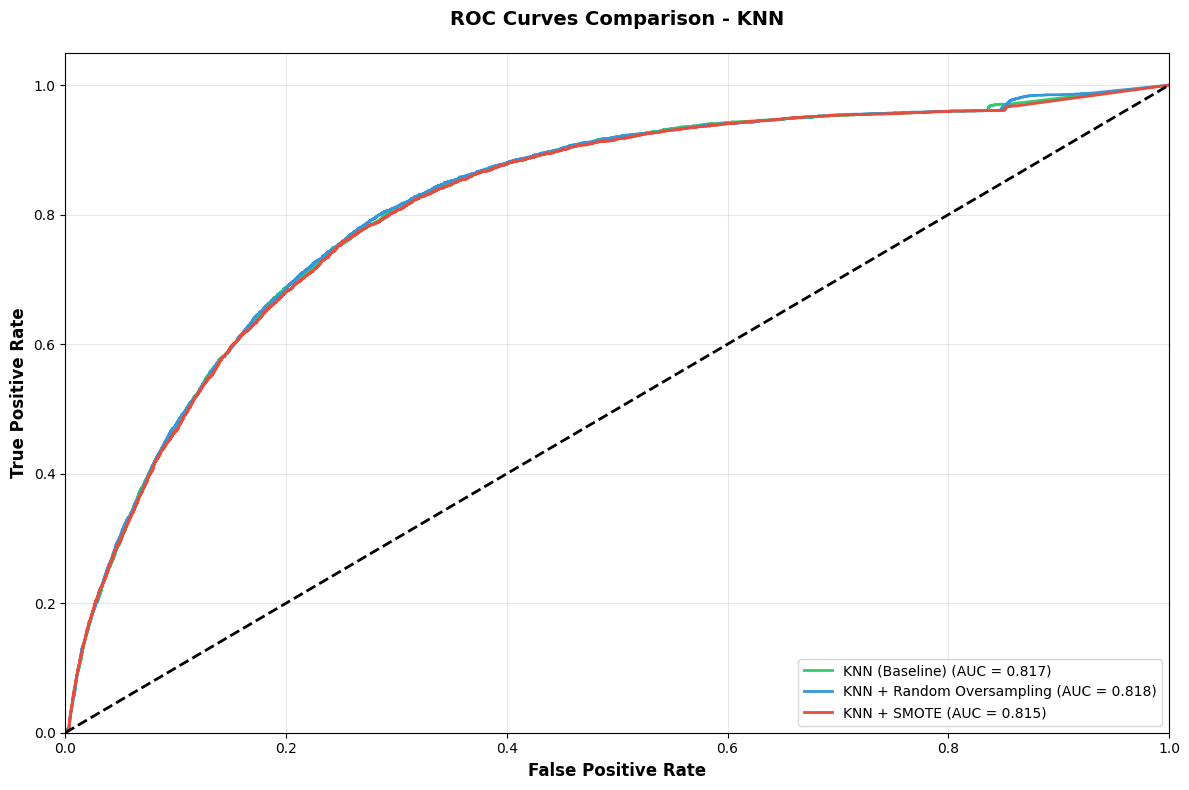

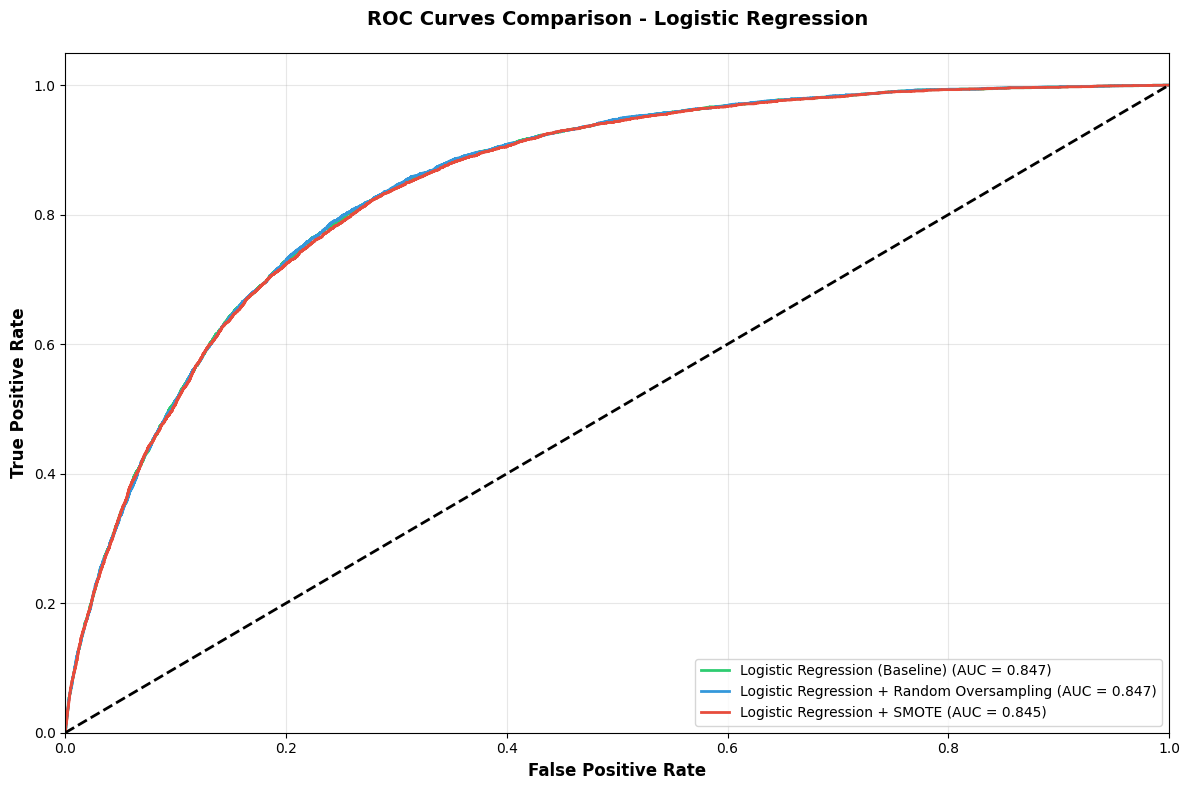

In [ ]:
def plot_model_comparison(model_name):
    plt.figure(figsize=(12, 8))
    
    std_scaler_base = StandardScaler()
    X_train_scaled = std_scaler_base.fit_transform(X_train1)
    X_val_scaled_base = std_scaler_base.transform(X_val1)
    
    std_scaler_ro = StandardScaler()
    X_train_ro_scaled = std_scaler_ro.fit_transform(X_train1_ro)
    X_val_scaled_ro = std_scaler_ro.transform(X_val1)
    
    std_scaler_smote = StandardScaler()
    X_train_smote_scaled = std_scaler_smote.fit_transform(X_train1_smote)
    X_val_scaled_smote = std_scaler_smote.transform(X_val1)
    
    if model_name == "KNN":
        base_model = KNeighborsClassifier(n_neighbors=int(math.sqrt(X_train1.shape[0])), weights='distance')
        ro_model = KNeighborsClassifier(n_neighbors=int(math.sqrt(X_train1_ro.shape[0])), weights='distance')
        smote_model = KNeighborsClassifier(n_neighbors=int(math.sqrt(X_train1_smote.shape[0])), weights='distance')
    elif model_name == "Logistic Regression":
        base_model = LogisticRegression()
        ro_model = LogisticRegression()
        smote_model = LogisticRegression()

    models = {
        f'{model_name} (Baseline)': (base_model, X_train_scaled, X_val_scaled_base, y_train1),
        f'{model_name} + Random Oversampling': (ro_model, X_train_ro_scaled, X_val_scaled_ro, y_train1_ro),
        f'{model_name} + SMOTE': (smote_model, X_train_smote_scaled, X_val_scaled_smote, y_train1_smote),
    }
    
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
    
    for (name, (model, X_train, X_val, y_train)), color in zip(models.items(), colors):
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val1, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curves Comparison - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/{model_name.lower().replace(" ", "_")}_roc_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison("KNN")
plot_model_comparison("Logistic Regression")